SCENIC + works with both scRNA seq data and ATAC seq data to build the gene regulatory network when we have multiome data. 
Using dnmt3a_tet2 mutated data 

In [3]:
print("You can do it Sanketh")

You can do it Sanketh


In [5]:
#Importing the modules  
import numpy as np
import pandas as pd
import matplotlib as pl
import scanpy as sc
import igraph
import loompy as lp
import anndata
from scipy import io
from scipy.sparse import coo_matrix, csr_matrix
import pyscenic
import os
from arboreto.algo import grnboost2



In [6]:
adata = anndata.read_h5ad("./merged_seurat.h5ad")

In [7]:
adata.obs["seurat_clusters"]

AAACCTGAGACTTGAA-1_GSM7056033_30week_dnmt3a_45_1                      T cells
AAACCTGAGTTTAGGA-1_GSM7056033_30week_dnmt3a_45_1               CXCR6+ T cells
AAACCTGCACGGCTAC-1_GSM7056033_30week_dnmt3a_45_1                      B cells
AAACCTGCAGCTATTG-1_GSM7056033_30week_dnmt3a_45_1               CXCR6+ T cells
AAACCTGGTCACACGC-1_GSM7056033_30week_dnmt3a_45_1               CXCR6+ T cells
                                                              ...            
TTTGTCAGTTACGGAG-1_GSM7056037_30week_wt_45_1                Mixed Lymphocytes
TTTGTCAGTTGTCGCG-1_GSM7056037_30week_wt_45_1          Inflamatory Macrophages
TTTGTCATCAAACAAG-1_GSM7056037_30week_wt_45_1                          T cells
TTTGTCATCCGAACGC-1_GSM7056037_30week_wt_45_1                          B cells
TTTGTCATCGTCGTTC-1_GSM7056037_30week_wt_45_1        Resident-like Macrophages
Name: seurat_clusters, Length: 16496, dtype: category
Categories (12, object): ['B cells', 'CXCR6+ T cells', 'Dendritic cells', 'Inflamatory M

In [9]:
adata

AnnData object with n_obs × n_vars = 16496 × 3558
    obs: 'nCount_RNA', 'nFeature_RNA', 'Cellbarcode', 'sample_geo', 'mutation', 'genotype', 'percent.mt', 'S.Score', 'G2M.Score', 'Phase', 'RNA_snn_res.0.7', 'seurat_clusters', 'pANN_0.25_0.09_510', 'genotype_clusters', 'genotype_clusters_ind'
    var: 'vf_vst_counts_mean', 'vf_vst_counts_variance', 'vf_vst_counts_variance.expected', 'vf_vst_counts_variance.standardized', 'vf_vst_counts_variable', 'vf_vst_counts_rank', 'var.features', 'var.features.rank'
    obsm: 'X_harmony', 'X_pca', 'X_umap'

In [10]:

adata.var_names

Index(['Sox17', 'Mybl1', 'Tcf24', 'Prex2', 'Sulf1', 'Prdm14', 'Msc', 'Terf1',
       'Stau2', 'Pi15',
       ...
       'Smc3', 'Gpam', 'Tcf7l2', 'Vax1', 'Emx2', 'Nanos1', 'Zfp950',
       'CR974586.5', 'AC125149.3', 'AC168977.1'],
      dtype='object', length=3558)

In [11]:
rna = adata

In [12]:
rna

AnnData object with n_obs × n_vars = 16496 × 3558
    obs: 'nCount_RNA', 'nFeature_RNA', 'Cellbarcode', 'sample_geo', 'mutation', 'genotype', 'percent.mt', 'S.Score', 'G2M.Score', 'Phase', 'RNA_snn_res.0.7', 'seurat_clusters', 'pANN_0.25_0.09_510', 'genotype_clusters', 'genotype_clusters_ind'
    var: 'vf_vst_counts_mean', 'vf_vst_counts_variance', 'vf_vst_counts_variance.expected', 'vf_vst_counts_variance.standardized', 'vf_vst_counts_variable', 'vf_vst_counts_rank', 'var.features', 'var.features.rank'
    obsm: 'X_harmony', 'X_pca', 'X_umap'

In [72]:
cellAnnot = rna.obs

In [14]:
sc.set_figure_params(facecolor="white")

/Users/xsankt/anaconda3/envs/pyscenic_env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/xsankt/anaconda3/envs/pyscenic_env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


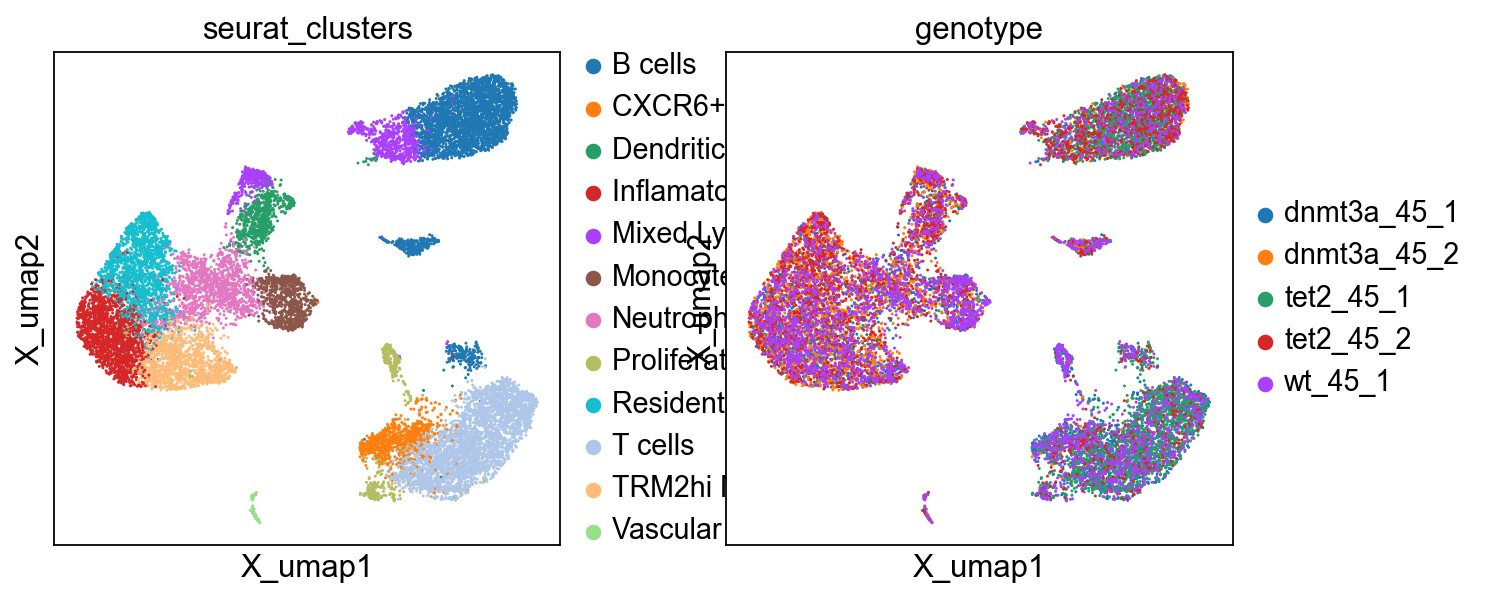

In [15]:
sc.pl.embedding(rna, "X_umap", color=["seurat_clusters", "genotype"])

##Preperation for scenic : Need to make a loom file for this 

In [16]:
tfs_path = "./mm_mgi_tfs.txt"

In [23]:
loom_path = "./data/week30/pyscenic/input.loom"
loom_path_output = "./data/week30/pyscenic/output.loom"
tfs = [tf.strip() for tf in open(tfs_path)]

Its a good idea to check if the transcription factors are matching in the gene list in general atleast more than 50 percent should match

In [24]:
# as a general QC. We inspect that our object has transcription factors listed in our main annotations.
print(
    f"%{np.sum(rna.var.index.isin(tfs))} out of {len(tfs)} TFs are found in the object"
)

%1688 out of 1721 TFs are found in the object


Usage of only highly variable genes

Creating a loom file now to prepare for scenic

In [19]:
rna

AnnData object with n_obs × n_vars = 16496 × 3558
    obs: 'nCount_RNA', 'nFeature_RNA', 'Cellbarcode', 'sample_geo', 'mutation', 'genotype', 'percent.mt', 'S.Score', 'G2M.Score', 'Phase', 'RNA_snn_res.0.7', 'seurat_clusters', 'pANN_0.25_0.09_510', 'genotype_clusters', 'genotype_clusters_ind'
    var: 'vf_vst_counts_mean', 'vf_vst_counts_variance', 'vf_vst_counts_variance.expected', 'vf_vst_counts_variance.standardized', 'vf_vst_counts_variable', 'vf_vst_counts_rank', 'var.features', 'var.features.rank'
    uns: 'seurat_clusters_colors', 'genotype_colors'
    obsm: 'X_harmony', 'X_pca', 'X_umap'

In [20]:
rna.obs_names

Index(['AAACCTGAGACTTGAA-1_GSM7056033_30week_dnmt3a_45_1',
       'AAACCTGAGTTTAGGA-1_GSM7056033_30week_dnmt3a_45_1',
       'AAACCTGCACGGCTAC-1_GSM7056033_30week_dnmt3a_45_1',
       'AAACCTGCAGCTATTG-1_GSM7056033_30week_dnmt3a_45_1',
       'AAACCTGGTCACACGC-1_GSM7056033_30week_dnmt3a_45_1',
       'AAACCTGGTGGAAAGA-1_GSM7056033_30week_dnmt3a_45_1',
       'AAACCTGGTTAGGGTG-1_GSM7056033_30week_dnmt3a_45_1',
       'AAACCTGTCAACGCTA-1_GSM7056033_30week_dnmt3a_45_1',
       'AAACGGGAGCCAACAG-1_GSM7056033_30week_dnmt3a_45_1',
       'AAACGGGAGGTGACCA-1_GSM7056033_30week_dnmt3a_45_1',
       ...
       'TTTGTCAAGTCAAGGC-1_GSM7056037_30week_wt_45_1',
       'TTTGTCAAGTTAACGA-1_GSM7056037_30week_wt_45_1',
       'TTTGTCACACCGGAAA-1_GSM7056037_30week_wt_45_1',
       'TTTGTCACAGTTAACC-1_GSM7056037_30week_wt_45_1',
       'TTTGTCAGTAAACACA-1_GSM7056037_30week_wt_45_1',
       'TTTGTCAGTTACGGAG-1_GSM7056037_30week_wt_45_1',
       'TTTGTCAGTTGTCGCG-1_GSM7056037_30week_wt_45_1',
       'TTTGTC

In [41]:
j = np.array(rna.var.index)
rna.var.index
rna.obs.index
k = np.array(np.sum(rna.X.transpose() > 0, axis=0)).flatten()
l = np.array(np.sum(rna.X.transpose(), axis=0)).flatten()

In [26]:
row_attributes = {
    "Gene": np.array(rna.var.index),
}
col_attributes = {
    "CellID": np.array(rna.obs.index),
    "nGene": np.array(np.sum(rna.X.transpose() > 0, axis=0)).flatten(),
    "nUMI": np.array(np.sum(rna.X.transpose(), axis=0)).flatten()
}

lp.create(loom_path, rna.X.transpose(), row_attributes, col_attributes)

Once the loom file has been generated, we execute pyscenic to generate associations between TFs and genes. TF-gene associations are inferred by GRNBoost, and summarized by a directional weight between TFs and target genes. The output of this analysis is a table summarizing all reported associations with their importance weight.

Some steps below require indicating a number of cores (num_workers). Increase according to computing resources available

In [27]:
!arboreto_with_multiprocessing.py \
   {loom_path} \
   {tfs_path} \
    --method grnboost2 \
    --output adj.csv \
    --num_workers 20 \
    --seed 777

Loaded expression matrix of 16496 cells and 3558 genes in 1.1270241737365723 seconds...
Loaded 1721 TFs...
starting grnboost2 using 20 processes...
100%|███████████████████████████████████████| 3558/3558 [39:08<00:00,  1.51it/s]
Done in 2351.690843105316 seconds.


In [45]:
adj.csv = "adj.csv"
!pyscenic grn {loom_path} {tfs_path} -o $outpath_adj --num_workers {num_workers} --method grnboost2


2024-01-20 18:58:23,400 - pyscenic.cli.pyscenic - INFO - Loading expression matrix.

2024-01-20 18:58:27,227 - pyscenic.cli.pyscenic - INFO - Inferring regulatory networks.
preparing dask client
parsing input
creating dask graph
2 partitions
computing dask graph
/Users/sanketh/opt/anaconda3/envs/pyscenic_env/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 468.70 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
2024-01-20 18:58:40,730 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.06 GiB -- Worker memory limit: 4.00 GiB
2024-01-20 18:58:45,926 - distributed.nanny.memory - WARNING - Worker tcp://127.0.0.1:49546 (pid=72771) exceeded 95% memo

In [28]:
results_adjacencies = pd.read_csv("adj.csv", index_col=False, sep=",")
print(f"Number of associations: {results_adjacencies.shape[0]}")
results_adjacencies.head()

Number of associations: 258333


TF   target  importance
0   Ebf1    Cd79a   64.656428
1   Ebf1    Ms4a1   53.428870
2   Ebf1  H2-DMb2   50.876674
3  Cebpb     Lyz2   43.029429
4   Dab2     C1qa   36.797178

Visualize the distribution of weights for general inspection of the quantiles and thresholds obtained from pyscenic. As provided by the pyscenic grn step, the importance scores follow a unimodal distribution, with negative/positive values indicating TF-gene associations with less/more importance, respectively. From the right-tail of this distribution, we can recover the most relevant interactions between TFs and potential target genes, supported by gene expression values and the analysis done by pyscenic.

(-10.0, 10.0)

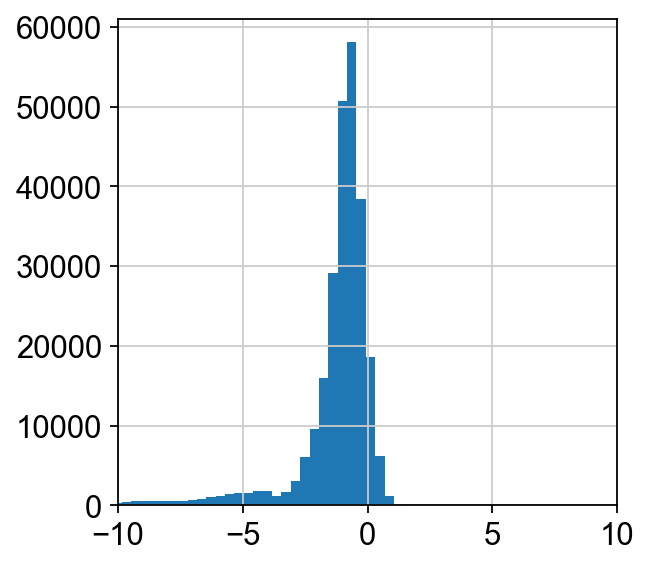

In [29]:
import matplotlib.pyplot as plt
plt.hist(np.log10(results_adjacencies["importance"]), bins=50)
plt.xlim([-10, 10])

As targets genes have DNA motifs at promoters (sequence specific DNA motifs), those can be used to link TFs to target genes. Next, we use an annotation of TF associations to Transcription Start Sites (TSSs) to refine this annotation.

Download TSS annotations precalculated by Aerts’s lab :

In [ ]:
#Motif2tf databases
#wget https://resources.aertslab.org/cistarget/motif2tf/motifs-v10nr_clust-nr.mgi-m0.001-o0.0.tbl
#cisTarget Databse 
#v1 feather files are not supported , use v2 files instead 
#500 bp up and 100bp down
wget https://resources.aertslab.org/cistarget/databases/mus_musculus/mm10/refseq_r80/mc_v10_clust/gene_based/mm10_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings.feather
#10kb up and down
wget https://resources.aertslab.org/cistarget/databases/mus_musculus/mm10/refseq_r80/mc_v10_clust/gene_based/mm10_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings.feather

In [30]:
#motif databses
motif_path = "../scenic/cisTarget_databases/motif2tf/motifs-v10nr_clust-nr.mgi-m0.001-o0.0.tbl"

In [31]:
import glob
import os

# ranking databases
db_glob = "../scenic/cisTarget_databases/mm10_v2/*feather"
db_names = " ".join(glob.glob(db_glob))

In [32]:
db_names

'../scenic/cisTarget_databases/mm10_v2/mm10_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings.feather ../scenic/cisTarget_databases/mm10_v2/mm10_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings.feather'

In [35]:
!pyscenic ctx adj.csv \
    {db_names} \
    --annotations_fname {motif_path} \
    --expression_mtx_fname {loom_path} \
    --output reg.csv \
    --mask_dropouts \
    --num_workers 20


2024-01-23 15:09:02,415 - pyscenic.cli.pyscenic - INFO - Creating modules.

2024-01-23 15:09:02,461 - pyscenic.cli.pyscenic - INFO - Loading expression matrix.

2024-01-23 15:09:03,721 - pyscenic.utils - INFO - Calculating Pearson correlations.

2024-01-23 15:09:03,734 - pyscenic.utils - WARNING - Note on correlation calculation: the default behaviour for calculating the correlations has changed after pySCENIC verion 0.9.16. Previously, the default was to calculate the correlation between a TF and target gene using only cells with non-zero expression values (mask_dropouts=True). The current default is now to use all cells to match the behavior of the R verision of SCENIC. The original settings can be retained by setting 'rho_mask_dropouts=True' in the modules_from_adjacencies function, or '--mask_dropouts' from the CLI.
	Dropout masking is currently set to [True].

2024-01-23 15:09:05,185 - pyscenic.utils - INFO - Creating modules.

2024-01-23 15:09:09,967 - pyscenic.cli.pyscenic - IN

It is important to check that most cells have a substantial fraction of expressed/detected genes in the calculation of the AUC. The following histogram gives an idea of the distribution and allows selection of an appropriate threshold. In this plot, a few thresholds are highlighted, with the number of genes selected shown in red text and the corresponding percentile in parentheses). See the relevant section in the R tutorial for more information.

By using the default setting for --auc_threshold of 0.05, we see that 1192 genes are selected for the rankings based on the plot below.

This step will use TFs to calculate Area Under the Curve scores, that summarize how well the gene expression observed in each cell can be associated by the regulation of target genes regulatred by the mentioned TFs.

Using the above-generated matrix of cell x TFs and those scores, we can calculate a new embedding using only those.

In [36]:
!pyscenic aucell \
    {loom_path} \
    reg.csv \
    --output {loom_path_output} \
    --num_workers 20


2024-01-23 15:40:24,178 - pyscenic.cli.pyscenic - INFO - Loading expression matrix.

2024-01-23 15:40:25,318 - pyscenic.cli.pyscenic - INFO - Loading gene signatures.
Create regulons from a dataframe of enriched features.
Additional columns saved: []

2024-01-23 15:40:25,697 - pyscenic.cli.pyscenic - INFO - Calculating cellular enrichment.

2024-01-23 15:41:08,051 - pyscenic.cli.pyscenic - INFO - Writing results to file.
/Users/xsankt/anaconda3/envs/pyscenic_env/lib/python3.10/site-packages/pyscenic/cli/utils.py:347: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, threshold in auc_thresholds.iteritems()


In [37]:
import json
import zlib
import base64

# collect SCENIC AUCell output
lf = lp.connect(loom_path_output, mode="r+", validate=False)
auc_mtx = pd.DataFrame(lf.ca.RegulonsAUC, index=lf.ca.CellID)
lf.close()

In [53]:
import anndata as ad

ad_auc_mtx = ad.AnnData(auc_mtx)
sc.pp.neighbors(ad_auc_mtx, n_neighbors=10, metric="correlation")
sc.tl.umap(ad_auc_mtx)
sc.tl.tsne(ad_auc_mtx)

         Falling back to preprocessing with `sc.pp.pca` and default params.


/Users/xsankt/anaconda3/envs/pyscenic_env/lib/python3.10/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


In [54]:
rna.obsm["X_umap_aucell"] = ad_auc_mtx.obsm["X_umap"]
rna.obsm["X_tsne_aucell"] = ad_auc_mtx.obsm["X_tsne"]

/Users/xsankt/anaconda3/envs/pyscenic_env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


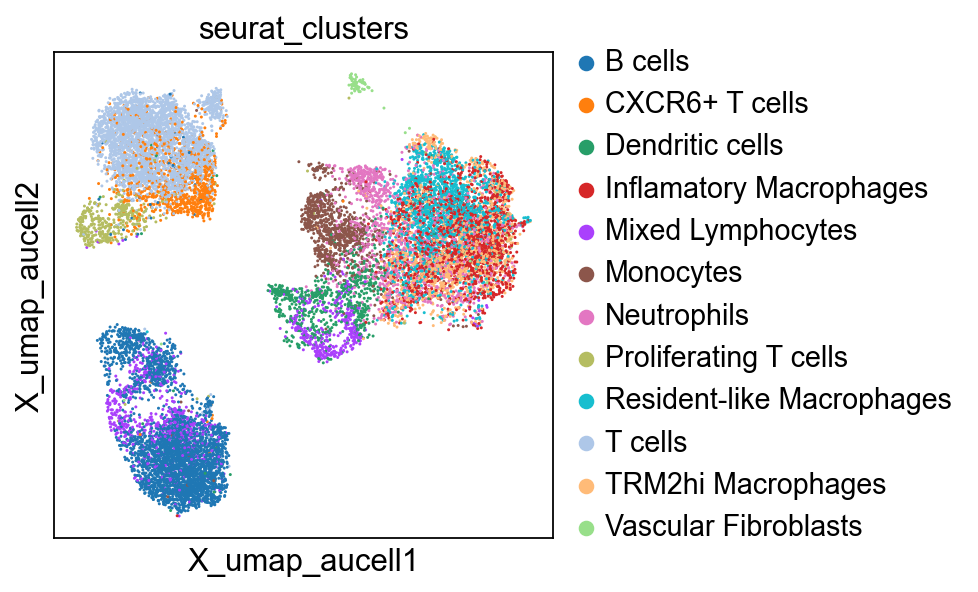

In [56]:
sc.pl.embedding(rna, basis="X_umap_aucell", color="seurat_clusters")

Now running the tsne 

/Users/xsankt/anaconda3/envs/pyscenic_env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


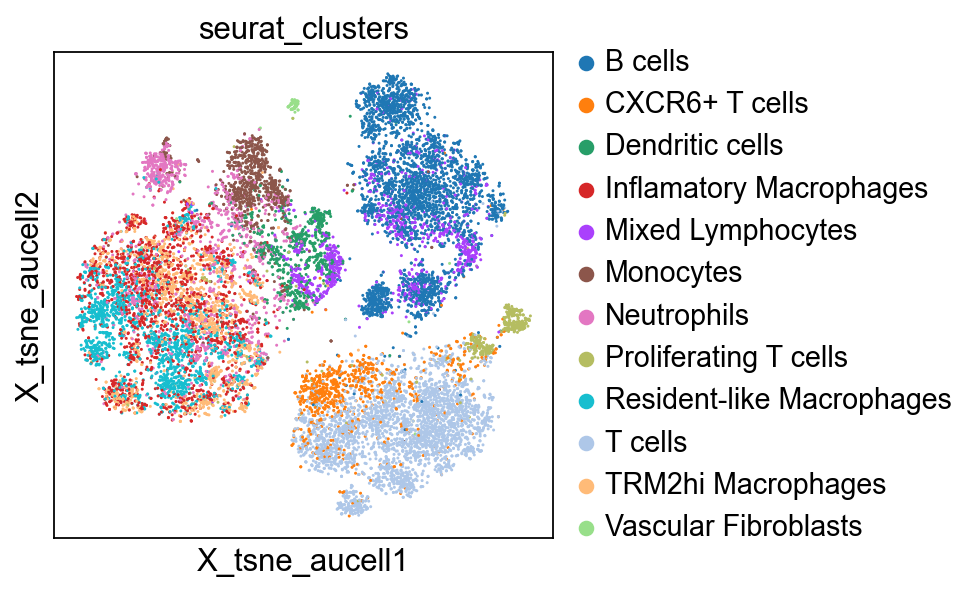

In [57]:
sc.pl.embedding(rna, basis="X_tsne_aucell", color="seurat_clusters")

Heat Map for auc activity :

In [43]:
auc_mtx["genotype_clusters"] = rna.obs["genotype_clusters"]
mean_auc_by_cell_type = auc_mtx.groupby("genotype_clusters").mean()

/var/folders/9s/h4mr9w4j4zdbdr1b37lqck4r0000gn/T/ipykernel_35790/3869451569.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean_auc_by_cell_type = auc_mtx.groupby("genotype_clusters").mean()


In [45]:
top_n = 50
top_tfs = mean_auc_by_cell_type.max(axis=0).sort_values(ascending=False).head(top_n)
mean_auc_by_cell_type_top_n = mean_auc_by_cell_type[
    [c for c in mean_auc_by_cell_type.columns if c in top_tfs]
]

Once we know the top TF-regulons involved in the biological system we are studying, we can inspect the activities estimated by each TF, based on the scores per cell, or the overall AUCs per cell-type explained by those TF (blue heatmap below).

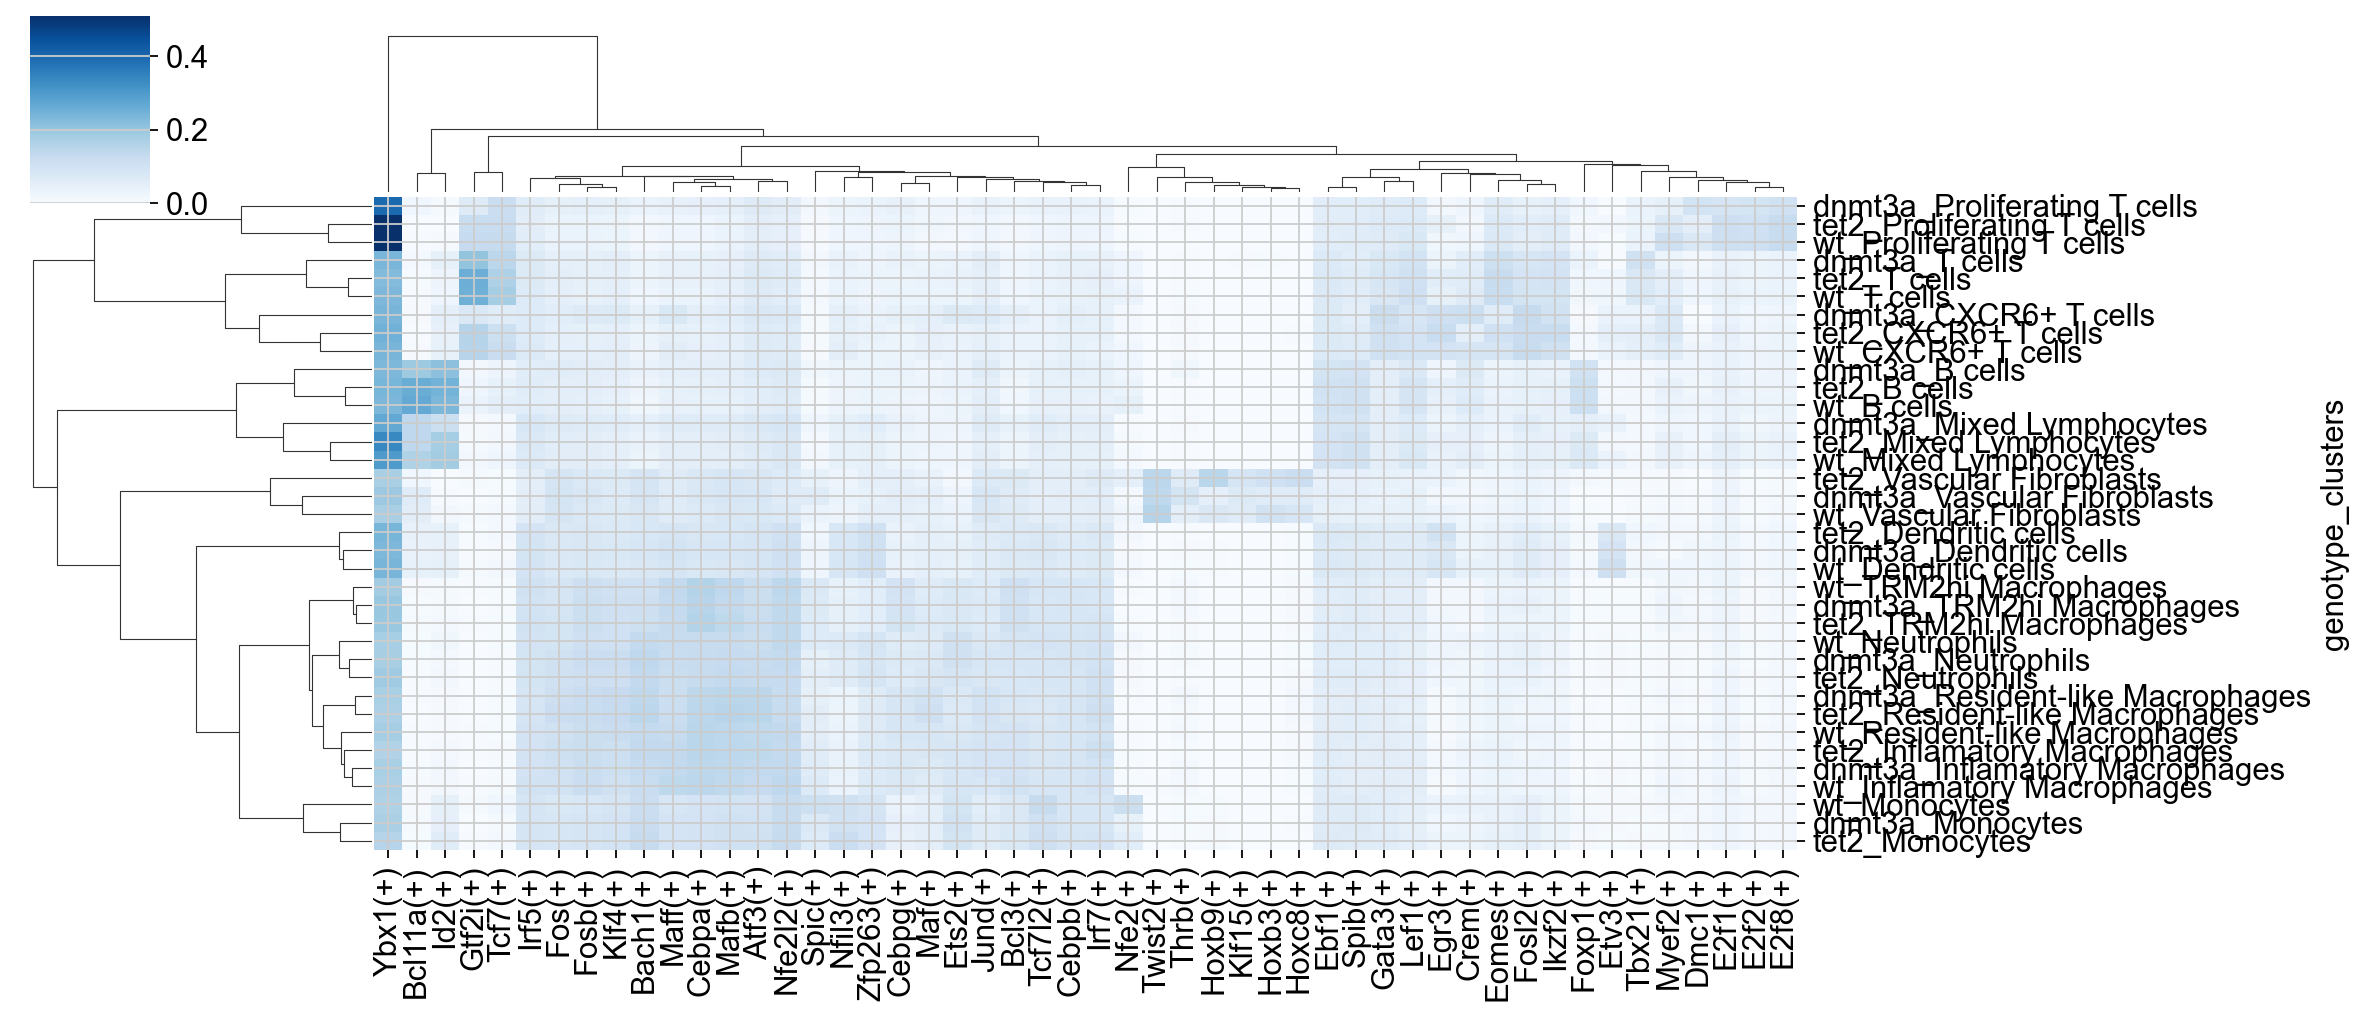

In [46]:
import seaborn as sns
sns.clustermap(
    mean_auc_by_cell_type_top_n,
    figsize=[15, 6.5],
    cmap="Blues",
    xticklabels=True,
    yticklabels=True,
)

As the red heatmap is suggesting that some TFs are strongly associated to particular cell types, we can verify the expression of their expression levels as an additional validation. This is done by matching the TF names we want to highlight, and visualize those using Scanpy’s (red heatmap).

In [51]:
tf_names = top_tfs.index.str.replace("\(\+\)", "")
rna_top_tfs = rna[:, rna.var_names.isin(tf_names)]

/var/folders/9s/h4mr9w4j4zdbdr1b37lqck4r0000gn/T/ipykernel_35790/508635316.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  tf_names = top_tfs.index.str.replace("\(\+\)", "")


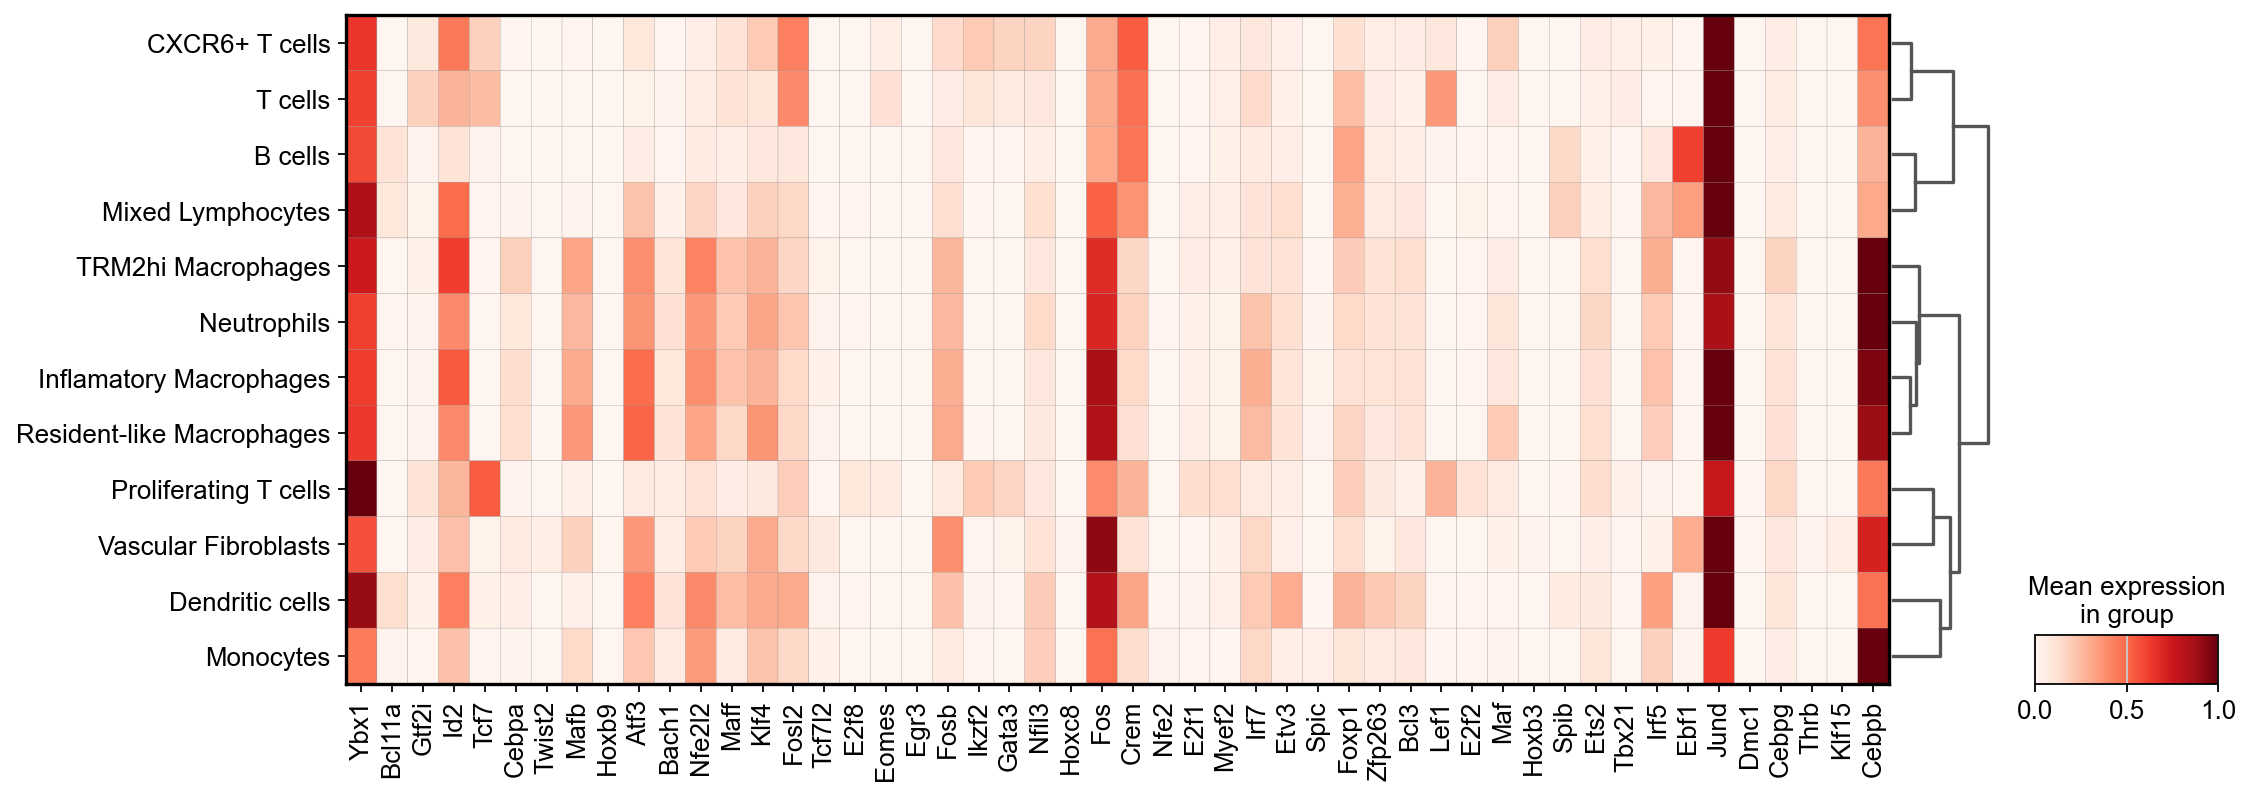

In [52]:
sc.pl.matrixplot(
    rna,
    tf_names,
    groupby="seurat_clusters",
    cmap="Reds",
    dendrogram=True,
    figsize=[15, 5.5],
    standard_scale="group",
)

Reload the loom file as the auc matrix was changed to plot the umap 

In [47]:
import json
import zlib
import base64

# collect SCENIC AUCell output
lf = lp.connect(loom_path_output, mode="r+", validate=False)
auc_mtx = pd.DataFrame(lf.ca.RegulonsAUC, index=lf.ca.CellID)
lf.close()

In [59]:
import os
import zlib
from pyscenic.plotting import plot_binarization
from pyscenic.export import add_scenic_metadata
from pyscenic.cli.utils import load_signatures
import matplotlib as mpl
import matplotlib.pyplot as plt
from pyscenic.plotting import plot_rss
import seaborn as sns

In [60]:
sc.settings.verbosity = 3 # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=150)

-----
anndata     0.10.4
scanpy      1.9.6
-----
PIL                 10.2.0
appnope             0.1.2
arboreto            NA
asttokens           NA
attr                23.2.0
boltons             NA
click               8.1.7
cloudpickle         3.0.0
comm                0.1.2
ctxcore             0.2.0
cycler              0.12.1
cython_runtime      NA
cytoolz             0.12.2
dask                2024.1.0
dateutil            2.8.2
debugpy             1.6.7
decorator           5.1.1
distributed         2024.1.0
exceptiongroup      1.0.4
executing           0.8.3
frozendict          2.4.0
fsspec              2023.12.2
h5py                3.10.0
igraph              0.11.3
ipykernel           6.28.0
jedi                0.18.1
jinja2              3.1.3
joblib              1.3.2
kiwisolver          1.4.5
llvmlite            0.39.1
locket              NA
loompy              3.0.7
lz4                 4.3.3
markupsafe          2.1.4
matplotlib          3.8.2
matplotlib_inline   0.1.6
mpl_toolkit

Extract relevant data from the integrated loom file

In [61]:
# scenic output
lf = lp.connect( loom_path_output, mode='r', validate=False )
meta = json.loads(zlib.decompress(base64.b64decode( lf.attrs.MetaData )))
exprMat = pd.DataFrame( lf[:,:], index=lf.ra.Gene, columns=lf.ca.CellID).T
auc_mtx = pd.DataFrame( lf.ca.RegulonsAUC, index=lf.ca.CellID)

In [62]:
# create a dictionary of regulons:
regulons = {}
for i,r in pd.DataFrame(lf.ra.Regulons,index=lf.ra.Gene).iteritems():
    regulons[i] =  list(r[r==1].index.values)

/var/folders/9s/h4mr9w4j4zdbdr1b37lqck4r0000gn/T/ipykernel_35790/37080085.py:3: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for i,r in pd.DataFrame(lf.ra.Regulons,index=lf.ra.Gene).iteritems():


In [65]:
lf.close

<bound method LoomConnection.close of <loompy.loompy.LoomConnection object at 0x2b20634f0>>

#Display motifs with motif logos

In [66]:
#helper function not yet integrated into pyscenic
from pyscenic.utils import load_motifs
import operator as op
from IPython.display import HTML,display

BASE_URL = "http://motifcollections.aertslab.org/v9/logos/"
COLUMN_NAME_LOGO = "MotifLogo"
COLUMN_NAME_MOTIF_ID = "MotifID"
COLUMN_NAME_TARGETS = "TargetGenes"

def display_logos(df: pd.DataFrame, top_target_genes: int = 3, base_url: str = BASE_URL):
    """
    :param df:
    :param base_url:
    """
    # Make sure the original dataframe is not altered.
    df = df.copy()
    
    # Add column with URLs to sequence logo.
    def create_url(motif_id):
        return '<img src="{}{}.png" style="max-height:124px;"></img>'.format(base_url, motif_id)
    df[("Enrichment", COLUMN_NAME_LOGO)] = list(map(create_url, df.index.get_level_values(COLUMN_NAME_MOTIF_ID)))
    
    # Truncate TargetGenes.
    def truncate(col_val):
        return sorted(col_val, key=op.itemgetter(1))[:top_target_genes]
    df[("Enrichment", COLUMN_NAME_TARGETS)] = list(map(truncate, df[("Enrichment", COLUMN_NAME_TARGETS)]))
    
    MAX_COL_WIDTH = pd.get_option('display.max_colwidth')
    pd.set_option('display.max_colwidth', 200)
    display(HTML(df.head().to_html(escape=False)))
    pd.set_option('display.max_colwidth', MAX_COL_WIDTH)

In [67]:
df_motifs = load_motifs("./reg.csv")

In [68]:
selected_motifs = ['Cebpb','Atf3']
df_motifs_sel = df_motifs.iloc[ [ True if x in selected_motifs else False for x in df_motifs.index.get_level_values('TF') ] ,:]

In [69]:
#display_logos(df_motifs.head())
display_logos( df_motifs_sel.sort_values([('Enrichment','NES')], ascending=False).head(9))

Regulon specificity scores (RSS) across predicted cell types

In [71]:
from pyscenic.rss import regulon_specificity_scores
from pyscenic.plotting import plot_rss
import matplotlib.pyplot as plt
from adjustText import adjust_text
import seaborn as sns
from pyscenic.binarization import binarize

#Calculate RSS

In [76]:
rss_cellType = regulon_specificity_scores( auc_mtx, cellAnnot['seurat_clusters'] )
rss_cellType

Aff4(+)  Arid3a(+)  Arid5b(+)  Arntl(+)  Ascl2(+)  \
T cells                    0.298816   0.254250   0.318769  0.318600  0.330759   
CXCR6+ T cells             0.220202   0.202499   0.228003  0.202621  0.264786   
B cells                    0.283989   0.322609   0.318882  0.305742  0.201509   
Inflamatory Macrophages    0.191121   0.283444   0.210064  0.250954  0.172545   
Resident-like Macrophages  0.180786   0.314173   0.199343  0.237432  0.172174   
Dendritic cells            0.176650   0.217665   0.203410  0.201057  0.172715   
TRM2hi Macrophages         0.180975   0.277477   0.187681  0.226948  0.170289   
Neutrophils                0.175860   0.247986   0.187653  0.207796  0.169523   
Proliferating T cells      0.182520   0.174525   0.178304  0.194020  0.191793   
Mixed Lymphocytes          0.192126   0.243018   0.209891  0.197611  0.174856   
Monocytes                  0.196130   0.209381   0.202714  0.222945  0.176789   
Vascular Fibroblasts       0.167445   0.172466   0.187356  0.178000  0.168896   

                            Atf1(+)   Atf3(+)   Atf4(+)   Atf5(+)  Bach1(+)  \
T cells                    0.276319  0.307064  0.330131  0.312875  0.246499   
CXCR6+ T cells             0.221919  0.217353  0.221407  0.258117  0.196625   
B cells                    0.259709  0.296860  0.397709  0.230749  0.243448   
Inflamatory Macrophages    0.202227  0.313988  0.260299  0.202596  0.335321   
Resident-like Macrophages  0.185576  0.326560  0.249582  0.224275  0.352265   
Dendritic cells            0.183205  0.221775  0.211716  0.175689  0.229233   
TRM2hi Macrophages         0.186730  0.281879  0.220378  0.181387  0.294839   
Neutrophils                0.180353  0.278864  0.220149  0.188826  0.311714   
Proliferating T cells      0.179223  0.189799  0.181597  0.179831  0.176807   
Mixed Lymphocytes          0.195620  0.225435  0.250242  0.195357  0.208398   
Monocytes                  0.202313  0.235982  0.213597  0.188973  0.262941   
Vascular Fibroblasts       0.169162  0.175174  0.180909  0.210908  0.177408   

                           ...  Zfp524(+)  Zfp595(+)  Zfp74(+)  Zfp740(+)  \
T cells                    ...   0.286563   0.323780  0.309524   0.233131   
CXCR6+ T cells             ...   0.235300   0.218291  0.214823   0.191443   
B cells                    ...   0.282927   0.344320  0.220315   0.230254   
Inflamatory Macrophages    ...   0.193424   0.222402  0.191731   0.177039   
Resident-like Macrophages  ...   0.182744   0.223998  0.193635   0.170273   
Dendritic cells            ...   0.181011   0.204199  0.204852   0.176754   
TRM2hi Macrophages         ...   0.205084   0.220154  0.179791   0.172460   
Neutrophils                ...   0.177662   0.203775  0.177077   0.188576   
Proliferating T cells      ...   0.203385   0.192025  0.186003   0.188421   
Mixed Lymphocytes          ...   0.202808   0.237702  0.203581   0.201097   
Monocytes                  ...   0.188549   0.203761  0.184104   0.233002   
Vascular Fibroblasts       ...   0.211992   0.168951  0.173760   0.170406   

                           Zfp768(+)  Zfp770(+)  Zfp941(+)  Zkscan17(+)  \
T cells                     0.293707   0.313518   0.298297     0.369349   
CXCR6+ T cells              0.223491   0.220349   0.210538     0.214094   
B cells                     0.429460   0.304887   0.377334     0.311434   
Inflamatory Macrophages     0.199744   0.194078   0.192107     0.216717   
Resident-like Macrophages   0.184846   0.184108   0.186086     0.195449   
Dendritic cells             0.228292   0.205879   0.180144     0.201637   
TRM2hi Macrophages          0.191851   0.182218   0.187808     0.200889   
Neutrophils                 0.184572   0.177791   0.175542     0.191267   
Proliferating T cells       0.174542   0.192452   0.192182     0.187646   
Mixed Lymphocytes           0.248257   0.221338   0.244108     0.202184   
Monocytes                   0.185014   0.192025   0.185790     0.203698   
Vascular Fibroblasts        0.169167   0.169

In [74]:
rss_cellType = regulon_specificity_scores( auc_mtx, cellAnnot['genotype_clusters'] )
rss_cellType

Aff4(+)  Arid3a(+)  Arid5b(+)  Arntl(+)  \
wt_T cells                        0.292909   0.249111   0.309813  0.311616   
wt_CXCR6+ T cells                 0.214295   0.198268   0.220963  0.199568   
wt_B cells                        0.263701   0.281841   0.290216  0.291349   
wt_Inflamatory Macrophages        0.185747   0.237588   0.193746  0.217577   
wt_Resident-like Macrophages      0.175437   0.226497   0.183835  0.206295   
wt_Dendritic cells                0.174084   0.193566   0.187190  0.185695   
wt_TRM2hi Macrophages             0.176899   0.233289   0.177763  0.205787   
wt_Neutrophils                    0.174956   0.210367   0.181420  0.194375   
wt_Proliferating T cells          0.181527   0.173133   0.176511  0.193128   
wt_Mixed Lymphocytes              0.185680   0.208552   0.198144  0.184339   
wt_Monocytes                      0.193515   0.198493   0.197636  0.215188   
wt_Vascular Fibroblasts           0.167445   0.170432   0.178275  0.171555   
dnmt3a_TRM2hi Macrophages         0.173086   0.207123   0.178424  0.191958   
dnmt3a_Mixed Lymphocytes          0.174888   0.193365   0.176449  0.178769   
dnmt3a_Inflamatory Macrophages    0.176425   0.211510   0.185944  0.204044   
dnmt3a_Vascular Fibroblasts       0.167445   0.169201   0.174760  0.173277   
dnmt3a_B cells                    0.198261   0.205212   0.194434  0.186812   
dnmt3a_Neutrophils                0.169001   0.198940   0.173329  0.181376   
dnmt3a_Resident-like Macrophages  0.175042   0.237455   0.183866  0.197616   
dnmt3a_Dendritic cells            0.170569   0.183157   0.177873  0.178460   
dnmt3a_Monocytes                  0.171549   0.176625   0.173239  0.175963   
dnmt3a_CXCR6+ T cells             0.173897   0.170226   0.172694  0.169961   
dnmt3a_Proliferating T cells      0.168286   0.168183   0.168726  0.168421   
dnmt3a_T cells                    0.168997   0.168095   0.171174  0.170587   
tet2_Resident-like Macrophages    0.171425   0.230038   0.178734  0.194407   
tet2_Dendritic cells              0.170082   0.189587   0.184665  0.182350   
tet2_Inflamatory Macrophages      0.173757   0.202940   0.180653  0.194578   
tet2_TRM2hi Macrophages           0.171327   0.202475   0.173451  0.183544   
tet2_B cells                      0.214386   0.217954   0.225920  0.199419   
tet2_Mixed Lymphocytes            0.176001   0.197885   0.183268  0.179554   
tet2_Neutrophils                  0.169892   0.196250   0.174185  0.180011   
tet2_T cells                      0.197284   0.180707   0.197408  0.189906   
tet2_Monocytes                    0.173175   0.178004   0.174503  0.179610   
tet2_Proliferating T cells        0.169604   0.169147   0.169696  0.169659   
tet2_CXCR6+ T cells               0.178299   0.173497   0.180217  0.173156   
tet2_Vascular Fibroblasts         0.167445   0.168545   0.173433  0.170332   

                                  Ascl2(+)   Atf1(+)   Atf3(+)   Atf4(+)  \
wt_T cells                        0.324695  0.272444  0.297962  0.321030   
wt_CXCR6+ T cells                 0.245789  0.219594  0.211227  0.214684   
wt_B cells                        0.196758  0.241943  0.263437  0.340355   
wt_Inflamatory Macrophages        0.170534  0.192949  0.253661  0.220443   
wt_Resident-like Macrophages      0.170891  0.178890  0.234164  0.201516   
wt_Dendritic cells                0.171594  0.177609  0.194947  0.190326   
wt_TRM2hi Macrophages             0.170382  0.180923  0.234487  0.198067   
wt_Neutrophils                    0.168775  0.179353  0.230088  0.196944   
wt_Proliferating T cells          0.187304  0.177625  0.186675  0.179554   
wt_Mixed Lymphocytes              0.174772  0.188210  0.200069  0.217662   
wt_Monocytes                      0.175774  0.196605  0.217003  0.201587   
wt_Vascular Fibroblasts           0.169217  0.168831  0.171418  0.176018   
dnmt3a_TRM2hi Macrophages         0.168223  0.174607  0.210058  0.187797   
dnmt3a_Mixed Lymphocytes          0.170245  0.175999  0.184511  0.189795   
dnmt3a_I

In [75]:
rss_cellType = regulon_specificity_scores( auc_mtx, cellAnnot['genotype_clusters_ind'] )
rss_cellType

Aff4(+)  Arid3a(+)  Arid5b(+)  \
dnmt3a_45_1_T cells                    0.233871   0.197839   0.228082   
dnmt3a_45_1_CXCR6+ T cells             0.191971   0.182835   0.194952   
dnmt3a_45_1_B cells                    0.213005   0.210502   0.212655   
dnmt3a_45_1_Inflamatory Macrophages    0.178884   0.207600   0.179733   
dnmt3a_45_1_Resident-like Macrophages  0.173357   0.198340   0.176643   
dnmt3a_45_1_Dendritic cells            0.171896   0.182871   0.178377   
dnmt3a_45_1_TRM2hi Macrophages         0.173188   0.206342   0.173516   
dnmt3a_45_1_Neutrophils                0.173357   0.189578   0.175019   
dnmt3a_45_1_Proliferating T cells      0.173387   0.169254   0.172011   
dnmt3a_45_1_Mixed Lymphocytes          0.176933   0.186724   0.180119   
dnmt3a_45_1_Monocytes                  0.182558   0.183391   0.183631   
dnmt3a_45_1_Vascular Fibroblasts       0.167445   0.168303   0.172422   
dnmt3a_45_2_TRM2hi Macrophages         0.173086   0.207123   0.178424   
dnmt3a_45_2_Mixed Lymphocytes          0.174888   0.193365   0.176449   
dnmt3a_45_2_Inflamatory Macrophages    0.176425   0.211510   0.185944   
dnmt3a_45_2_Vascular Fibroblasts       0.167445   0.169201   0.174760   
dnmt3a_45_2_B cells                    0.198261   0.205212   0.194434   
dnmt3a_45_2_Neutrophils                0.169001   0.198940   0.173329   
dnmt3a_45_2_Resident-like Macrophages  0.175042   0.237455   0.183866   
dnmt3a_45_2_Dendritic cells            0.170569   0.183157   0.177873   
dnmt3a_45_2_Monocytes                  0.171549   0.176625   0.173239   
dnmt3a_45_2_CXCR6+ T cells             0.173897   0.170226   0.172694   
dnmt3a_45_2_Proliferating T cells      0.168286   0.168183   0.168726   
dnmt3a_45_2_T cells                    0.168997   0.168095   0.171174   
tet2_45_1_T cells                      0.255204   0.224828   0.273533   
tet2_45_1_B cells                      0.237494   0.238551   0.256182   
tet2_45_1_Mixed Lymphocytes            0.177735   0.185645   0.184394   
tet2_45_1_TRM2hi Macrophages           0.169122   0.172467   0.167675   
tet2_45_1_CXCR6+ T cells               0.191047   0.180254   0.191327   
tet2_45_1_Proliferating T cells        0.170838   0.169391   0.168879   
tet2_45_1_Monocytes                    0.168831   0.168814   0.167863   
tet2_45_1_Neutrophils                  0.167445   0.169476   0.168492   
tet2_45_1_Resident-like Macrophages    0.167445   0.171784   0.167705   
tet2_45_1_Inflamatory Macrophages      0.167702   0.171274   0.168973   
tet2_45_1_Dendritic cells              0.167445   0.169282   0.168599   
tet2_45_1_Vascular Fibroblasts         0.167445   0.168121   0.168845   
tet2_45_2_Resident-like Macrophages    0.171425   0.230038   0.178734   
tet2_45_2_Dendritic cells              0.170082   0.189587   0.184665   
tet2_45_2_Inflamatory Macrophages      0.173757   0.202940   0.180653   
tet2_45_2_TRM2hi Macrophages           0.171327   0.202475   0.173451   
tet2_45_2_B cells                      0.214386   0.217954   0.225920   
tet2_45_2_Mixed Lymphocytes            0.176001   0.197885   0.183268   
tet2_45_2_Neutrophils                  0.169892   0.196250   0.174185   
tet2_45_2_T cells                      0.197284   0.180707   0.197408   
tet2_45_2_Monocytes                    0.173175   0.178004   0.174503   
tet2_45_2_Proliferating T cells        0.169604   0.169147   0.169696   
tet2_45_2_CXCR6+ T cells               0.178299   0.173497   0.180217   
tet2_45_2_Vascular Fibroblasts         0.167445   0.168545   0.173433   
wt_45_1_Monocytes                      0.183864   0.186705   0.187240   
wt_45_1_T cells                        0.211374   0.185964   0.206513   
wt_45_1_TRM2hi Macrophages             0.172459   0.202490   0.173588   
wt_45_1_Inflamatory Macrophages        0.178940   0.207819   0.186233   
wt_45_1_Mixed Lymphocytes              0.172335   0.181674   0.177788   
wt_45_1_Vascular Fibroblasts           0.167445   0.169365   0.173680   
wt_45_1_Neutrophils      

#RSS panel plot with all cell types

ValueError: num must be an integer with 1 <= num <= 10, not 11

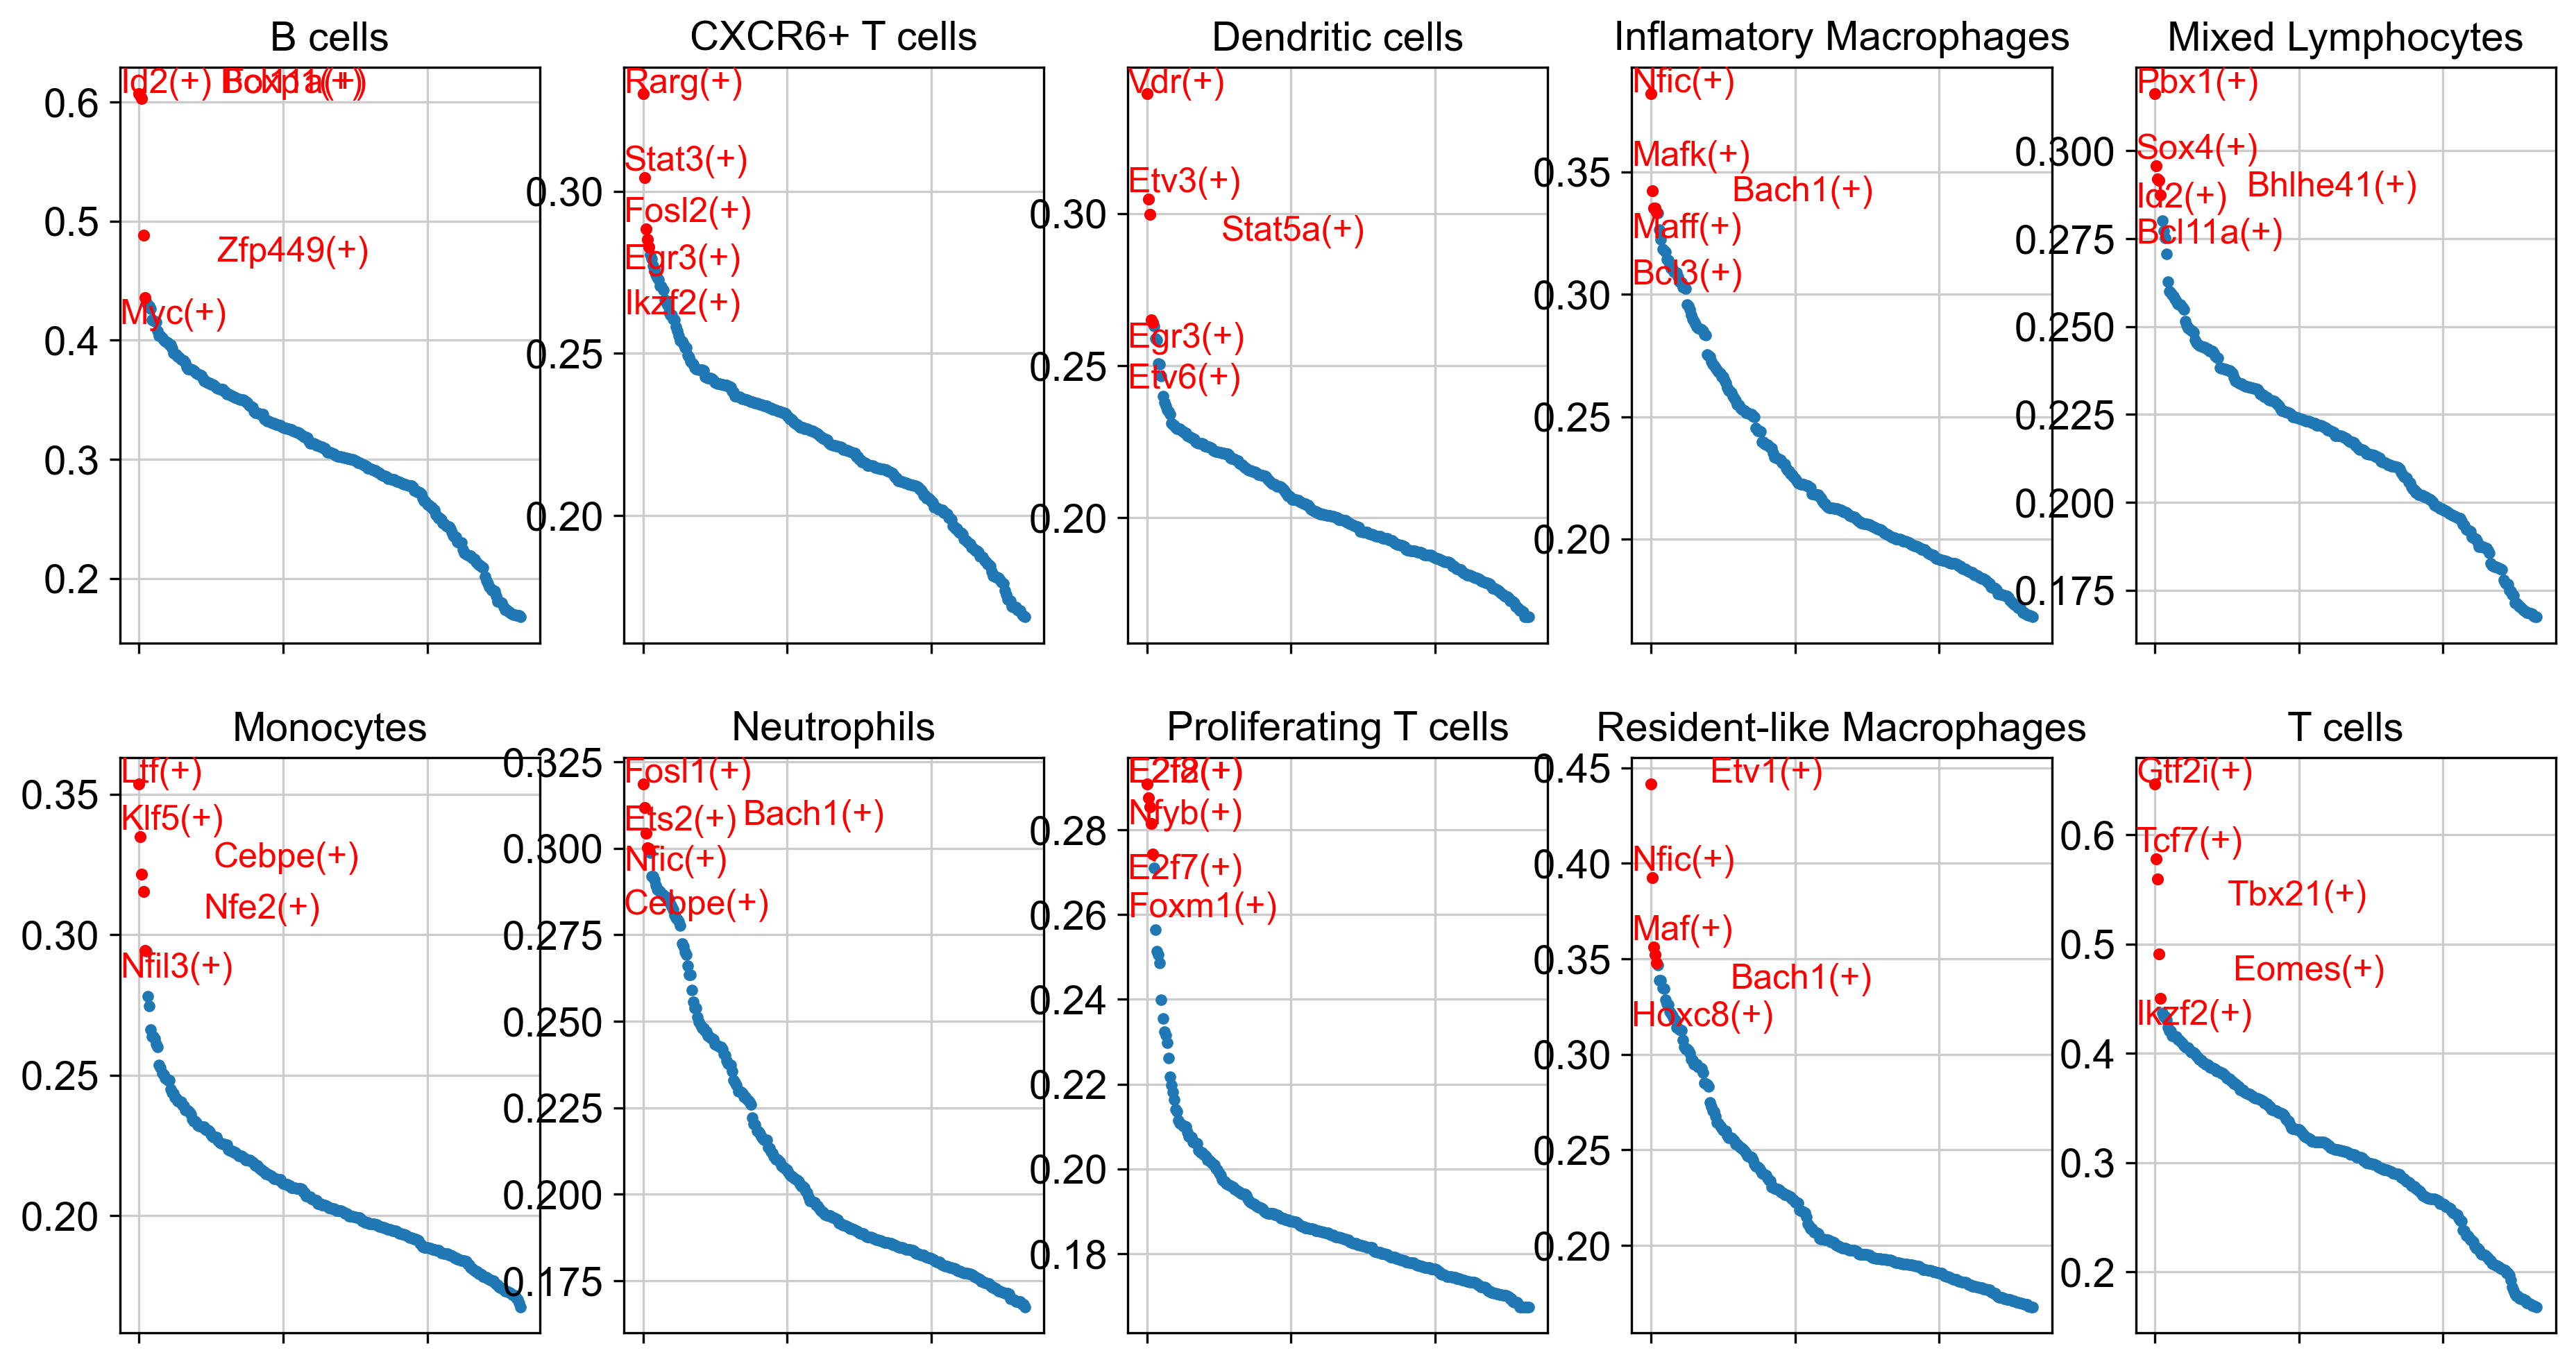

In [79]:
cats = sorted(list(set(cellAnnot['seurat_clusters'])))

fig = plt.figure(figsize=(15, 8))
for c,num in zip(cats, range(1,len(cats)+1)):
    x=rss_cellType.T[c]
    ax = fig.add_subplot(2,5,num)
    plot_rss(rss_cellType, c, top_n=5, max_n=None, ax=ax)
    ax.set_ylim( x.min()-(x.max()-x.min())*0.05 , x.max()+(x.max()-x.min())*0.05 )
    for t in ax.texts:
        t.set_fontsize(12)
    ax.set_ylabel('')
    ax.set_xlabel('')
    adjust_text(ax.texts, autoalign='xy', ha='right', va='bottom', precision=0.001 )
 
fig.text(0.5, 0.0, 'Regulon', ha='center', va='center', size='x-large')
fig.text(0.00, 0.5, 'Regulon specificity score (RSS)', ha='center', va='center', rotation='vertical', size='x-large')
plt.tight_layout()
plt.rcParams.update({
    'figure.autolayout': True,
        'figure.titlesize': 'large' ,
        'axes.labelsize': 'medium',
        'axes.titlesize':'large',
        'xtick.labelsize':'medium',
        'ytick.labelsize':'medium'
        })
plt.savefig("DNMT3A_TET2_MUT_cellType-RSS-top5.pdf", dpi=600, bbox_inches = "tight")
plt.show()

#Select the top 5 regulons from each cell type

In [81]:
topreg = []
for i,c in enumerate(cats):
    topreg.extend(
        list(rss_cellType.T[c].sort_values(ascending=False)[:5].index)
    )
topreg = list(set(topreg))

#Generate a Z-score for each regulon to enable comparison between regulons

In [80]:
auc_mtx_Z = pd.DataFrame( index=auc_mtx.index )
for col in list(auc_mtx.columns):
    auc_mtx_Z[ col ] = ( auc_mtx[col] - auc_mtx[col].mean()) / auc_mtx[col].std(ddof=0)
#auc_mtx_Z.sort_index(inplace=True)

/var/folders/9s/h4mr9w4j4zdbdr1b37lqck4r0000gn/T/ipykernel_35790/68287874.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  auc_mtx_Z[ col ] = ( auc_mtx[col] - auc_mtx[col].mean()) / auc_mtx[col].std(ddof=0)
/var/folders/9s/h4mr9w4j4zdbdr1b37lqck4r0000gn/T/ipykernel_35790/68287874.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  auc_mtx_Z[ col ] = ( auc_mtx[col] - auc_mtx[col].mean()) / auc_mtx[col].std(ddof=0)
/var/folders/9s/h4mr9w4j4zdbdr1b37lqck4r0000gn/T/ipykernel_35790/68287874.py:3: PerformanceWarning: DataFrame is h

#Generate a heatmap 

In [82]:
def palplot(pal, names, colors=None, size=1):
    n = len(pal)
    f, ax = plt.subplots(1, 1, figsize=(n * size, size))
    ax.imshow(np.arange(n).reshape(1, n),
              cmap=mpl.colors.ListedColormap(list(pal)),
              interpolation="nearest", aspect="auto")
    ax.set_xticks(np.arange(n) - .5)
    ax.set_yticks([-.5, .5])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    colors = n * ['k'] if colors is None else colors
    for idx, (name, color) in enumerate(zip(names, colors)):
        ax.text(0.0+idx, 0.0, name, color=color, horizontalalignment='center', verticalalignment='center')
    return f

In [83]:
colors = sns.color_palette('bright',n_colors=len(cats) )
colorsd = dict( zip( cats, colors ))
colormap = [ colorsd[x] for x in cellAnnot['seurat_clusters'] ]

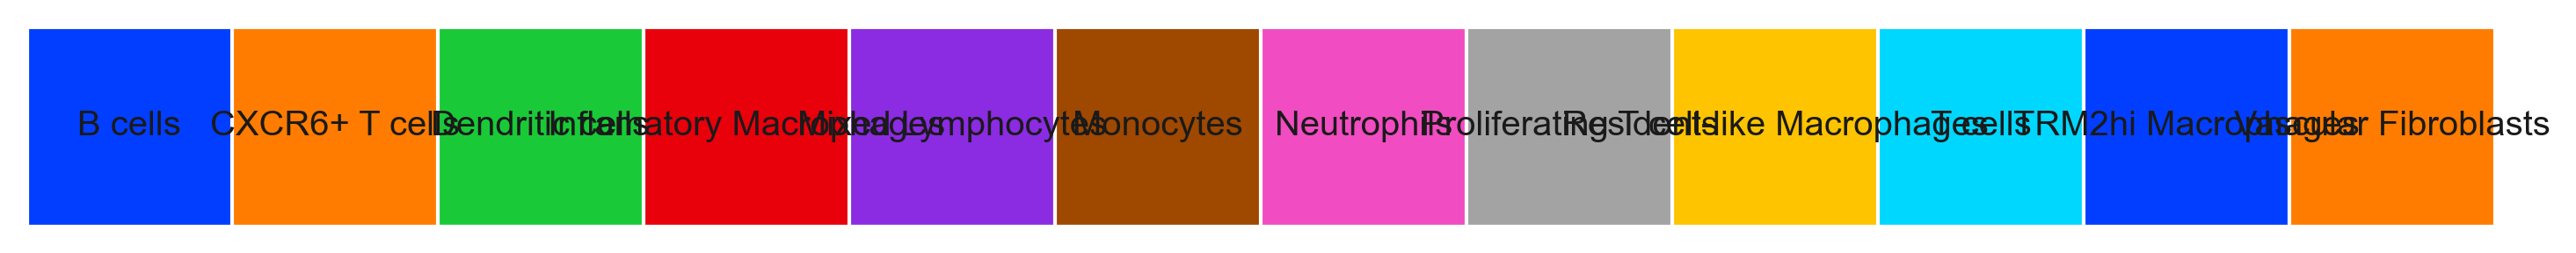

In [84]:
sns.set()
sns.set(font_scale=0.8)
fig = palplot( colors, cats, size=1.0)
#plt.savefig("PBMC10k_cellType-heatmap-legend-top5.pdf", dpi=600, bbox_inches = "tight")

/Users/xsankt/anaconda3/envs/pyscenic_env/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Users/xsankt/anaconda3/envs/pyscenic_env/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


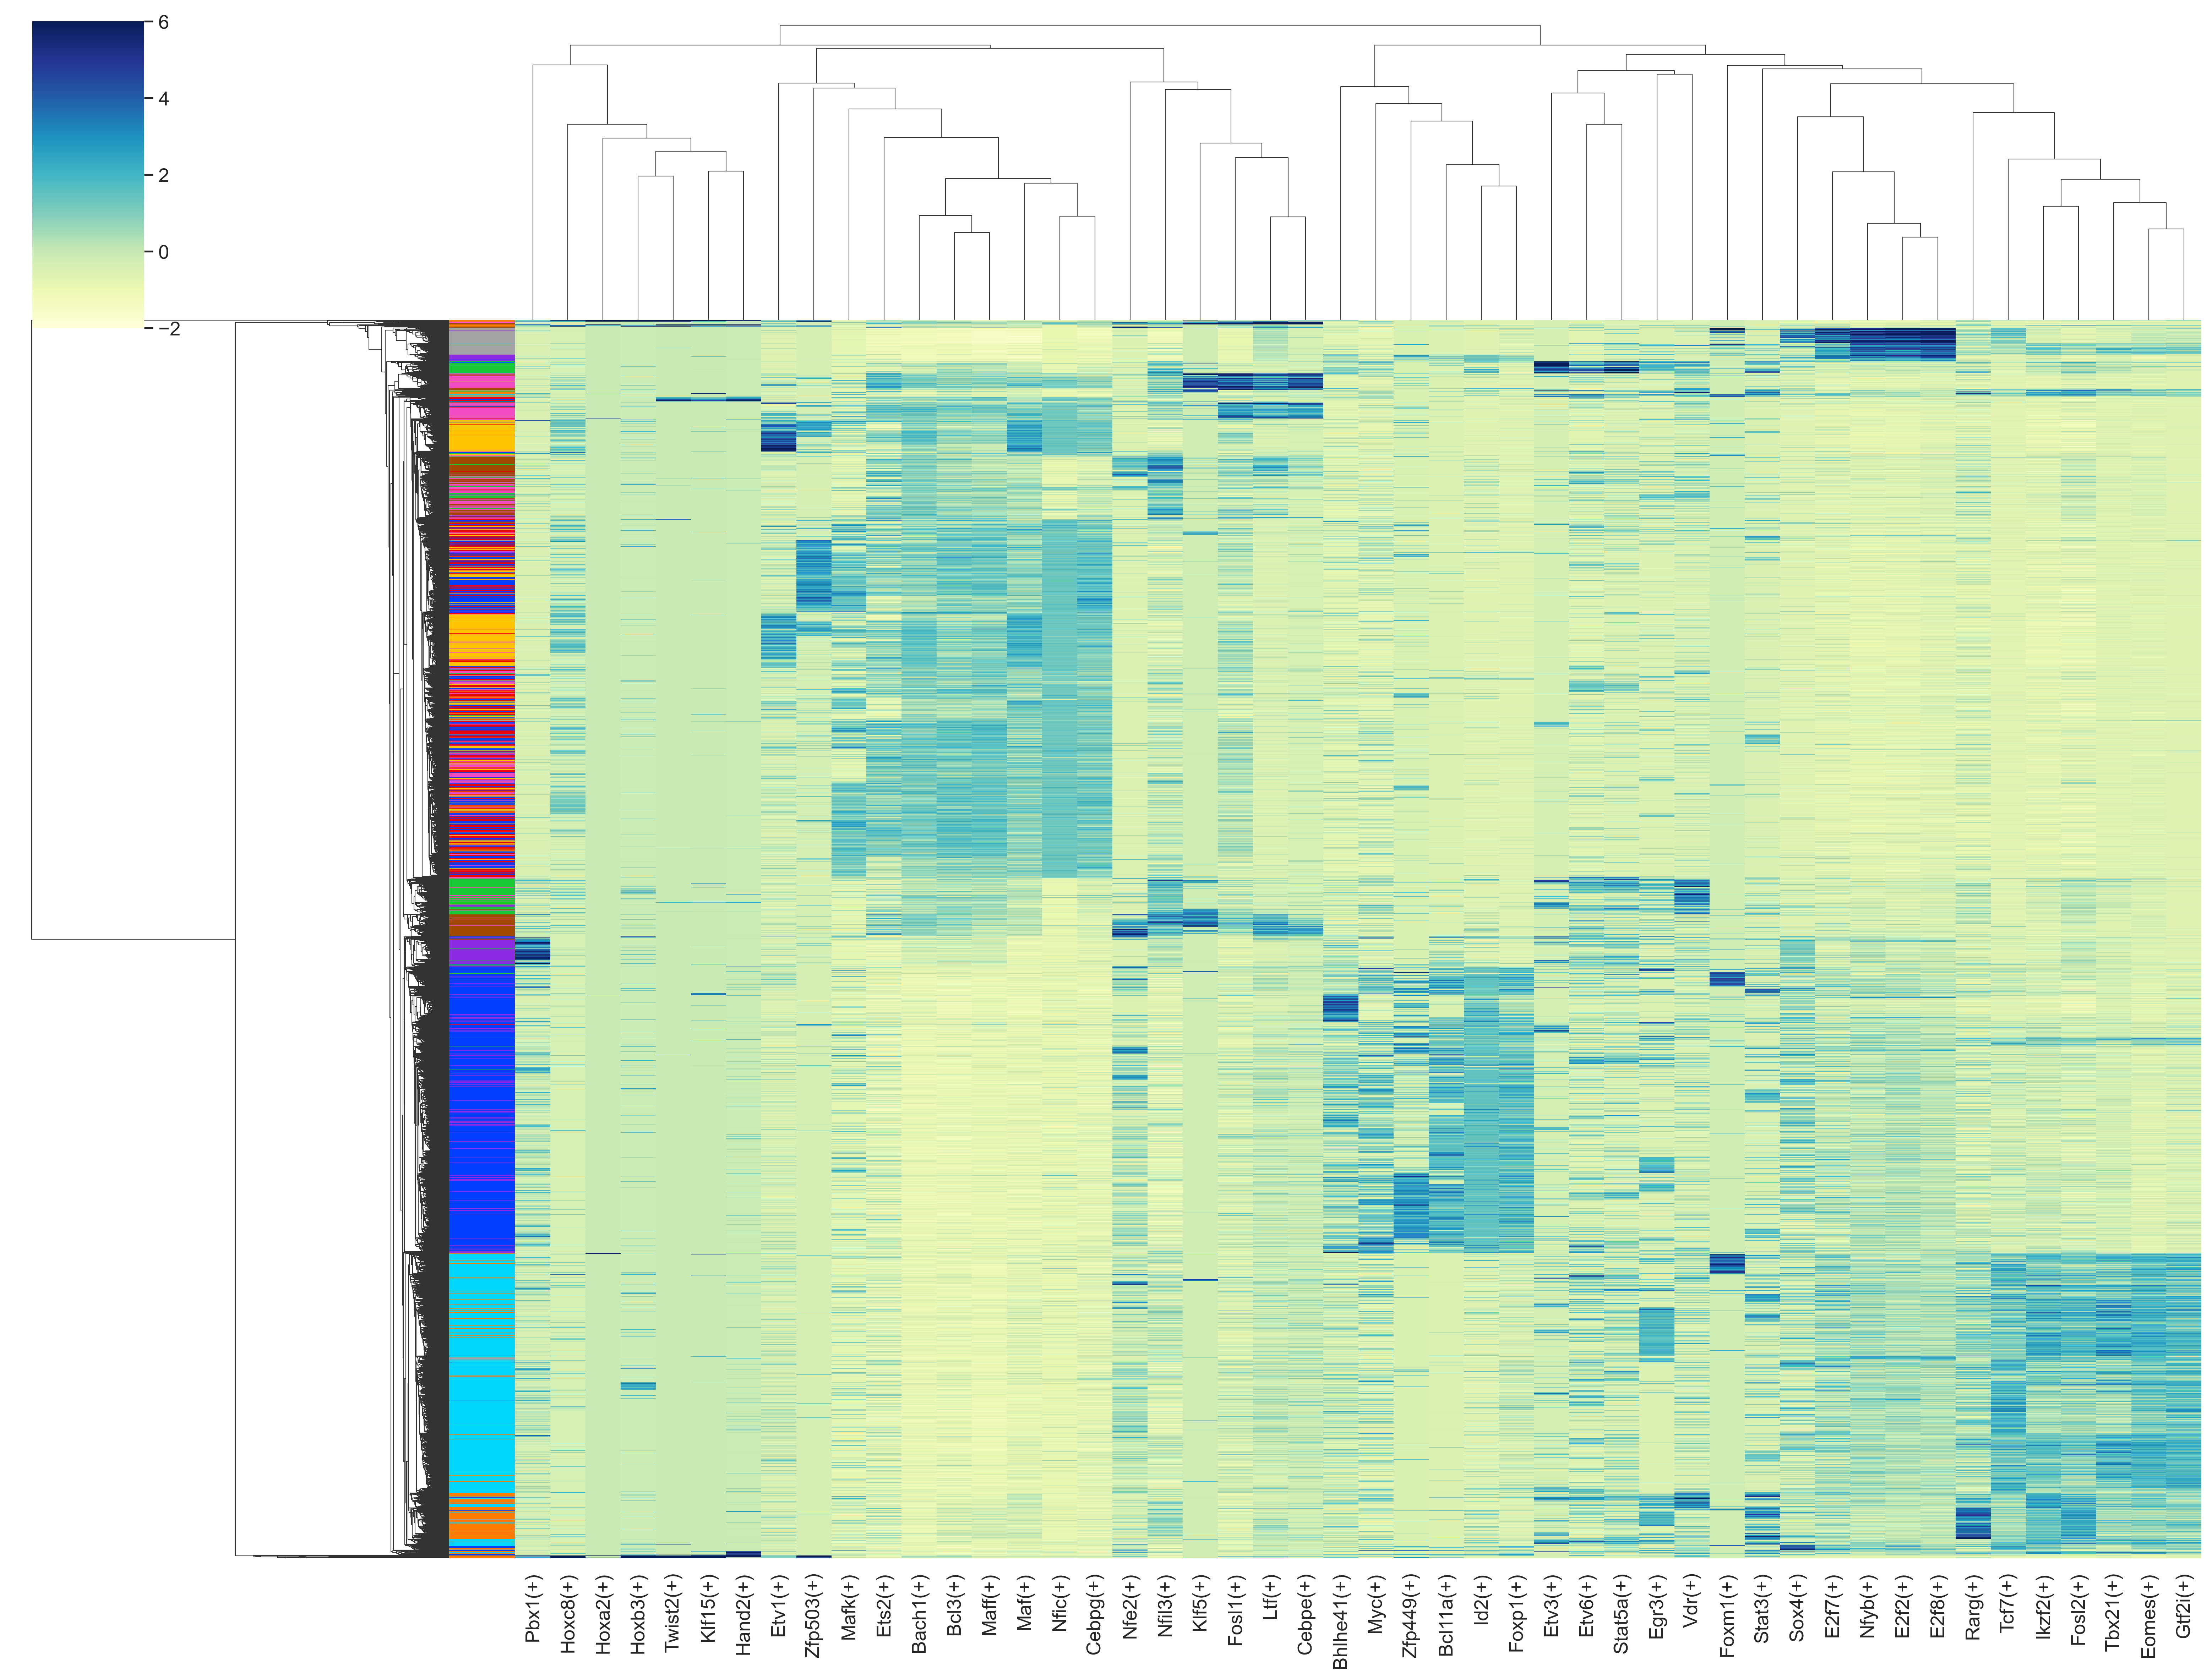

In [87]:
sns.set(font_scale=1.2)
g = sns.clustermap(auc_mtx_Z[topreg], annot=False,  square=False,  linecolor='gray',
    yticklabels=False, xticklabels=True, vmin=-2, vmax=6, row_colors=colormap,
    cmap="YlGnBu", figsize=(21,16) )
g.cax.set_visible(True)
g.ax_heatmap.set_ylabel('')
g.ax_heatmap.set_xlabel('')
plt.savefig("DNMT3A_TET2_cellType-heatmap-top5.pdf", dpi=600, bbox_inches = "tight")

#Generate a binary regulon activity matrix:

In [88]:

binary_mtx, auc_thresholds = binarize( auc_mtx, num_workers=20 )
binary_mtx.head()
#Write code to save the binary matrix as a csv file that can be imported into R 

Aff4(+)  Arid3a(+)  \
AAACCTGAGACTTGAA-1_GSM7056033_30week_dnmt3a_45_1        0          0   
AAACCTGAGTTTAGGA-1_GSM7056033_30week_dnmt3a_45_1        1          1   
AAACCTGCACGGCTAC-1_GSM7056033_30week_dnmt3a_45_1        1          0   
AAACCTGCAGCTATTG-1_GSM7056033_30week_dnmt3a_45_1        1          1   
AAACCTGGTCACACGC-1_GSM7056033_30week_dnmt3a_45_1        0          0   

                                                  Arid5b(+)  Arntl(+)  \
AAACCTGAGACTTGAA-1_GSM7056033_30week_dnmt3a_45_1          0         1   
AAACCTGAGTTTAGGA-1_GSM7056033_30week_dnmt3a_45_1          0         0   
AAACCTGCACGGCTAC-1_GSM7056033_30week_dnmt3a_45_1          0         0   
AAACCTGCAGCTATTG-1_GSM7056033_30week_dnmt3a_45_1          0         0   
AAACCTGGTCACACGC-1_GSM7056033_30week_dnmt3a_45_1          1         0   

                                                  Ascl2(+)  Atf1(+)  Atf3(+)  \
AAACCTGAGACTTGAA-1_GSM7056033_30week_dnmt3a_45_1         0        0        0   
AAACCTGAGTTTAGGA-1_GSM7056033_30week_dnmt3a_45_1         1        0        0   
AAACCTGCACGGCTAC-1_GSM7056033_30week_dnmt3a_45_1         0        0        0   
AAACCTGCAGCTATTG-1_GSM7056033_30week_dnmt3a_45_1         1        0        0   
AAACCTGGTCACACGC-1_GSM7056033_30week_dnmt3a_45_1         0        0        0   

                                                  Atf4(+)  Atf5(+)  Bach1(+)  \
AAACCTGAGACTTGAA-1_GSM7056033_30week_dnmt3a_45_1        0        1         0   
AAACCTGAGTTTAGGA-1_GSM7056033_30week_dnmt3a_45_1        0        1         0   
AAACCTGCACGGCTAC-1_GSM7056033_30week_dnmt3a_45_1        0        0         0   
AAACCTGCAGCTATTG-1_GSM7056033_30week_dnmt3a_45_1        0        0         0   
AAACCTGGTCACACGC-1_GSM7056033_30week_dnmt3a_45_1        0        0         0   

                                                  ...  Zfp524(+)  Zfp595(+)  \
AAACCTGAGACTTGAA-1_GSM7056033_30week_dnmt3a_45_1  ...          0          1   
AAACCTGAGTTTAGGA-1_GSM7056033_30week_dnmt3a_45_1  ...          0          0   
AAACCTGCACGGCTAC-1_GSM7056033_30week_dnmt3a_45_1  ...          1          0   
AAACCTGCAGCTATTG-1_GSM7056033_30week_dnmt3a_45_1  ...          0          1   
AAACCTGGTCACACGC-1_GSM7056033_30week_dnmt3a_45_1  ...          0          0   

                                                  Zfp74(+)  Zfp740(+)  \
AAACCTGAGACTTGAA-1_GSM7056033_30week_dnmt3a_45_1         0          0   
AAACCTGAGTTTAGGA-1_GSM7056033_30week_dnmt3a_45_1         0          0   
AAACCTGCACGGCTAC-1_GSM7056033_30week_dnmt3a_45_1         0          0   
AAACCTGCAGCTATTG-1_GSM7056033_30week_dnmt3a_45_1         0          0   
AAACCTGGTCACACGC-1_GSM7056033_30week_dnmt3a_45_1         0          0   

                                                  Zfp768(+)  Zfp770(+)  \
AAACCTGAGACTTGAA-1_GSM7056033_30week_dnmt3a_45_1          1          0   
AAACCTGAGTTTAGGA-1_GSM7056033_30week_dnmt3a_45_1          1          0   
AAACCTGCACGGCTAC-1_GSM7056033_30week_dnmt3a_45_1          1          0   
AAACCTGCAGCTATTG-1_GSM7056033_30week_dnmt3a_45_1          1          0   
AAACCTGGTCACACGC-1_GSM7056033_30week_dnmt3a_45_1          1          1   

                                                  Zfp941(+)  Zkscan17(+)  \
AAACCTGAGACTTGAA-1_GSM7056033_30week_dnmt3a_45_1          0            1   
AAACCTGAGTTTAGGA-1_GSM7056033_30week_dnmt3a_45_1          0            0   
AAACCTGCACGGCTAC-1_GSM7056033_30week_dnmt3a_45_1          0            0   
AAACCTGCAGCTATTG-1_GSM7056033_30week_dnmt3a_45_1          0            0   
AAACCTGGTCACACGC-1_GSM7056033_30week_dnmt3a_45_1          0            1   

                                                  Zkscan8(+)  Zscan22(+)  
AAACCTGAGACTTGAA-1_GSM7056033_30week_dnmt3a_45_1           0           1  
AAACCTGAGTTTAGGA-1_GSM7056033_30week_dnmt3a_45_1           0           0  
AAACCTGCACGGCTAC-1_GSM7056033_30week_dnmt3a_45_1           0           1  
AAACCTGCAGCTATTG-1_GSM7056033_30week_dnmt3a_45_1           0           0  
AAACCTGGTCACACGC-1_GSM705

Show the AUC distributions for selected regulons

/var/folders/9s/h4mr9w4j4zdbdr1b37lqck4r0000gn/T/ipykernel_35790/1396231683.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(auc_mtx[ r[i] ], ax=ax, norm_hist=True, bins=100)
/var/folders/9s/h4mr9w4j4zdbdr1b37lqck4r0000gn/T/ipykernel_35790/1396231683.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns

Text(0.5, -0.01, 'AUC')

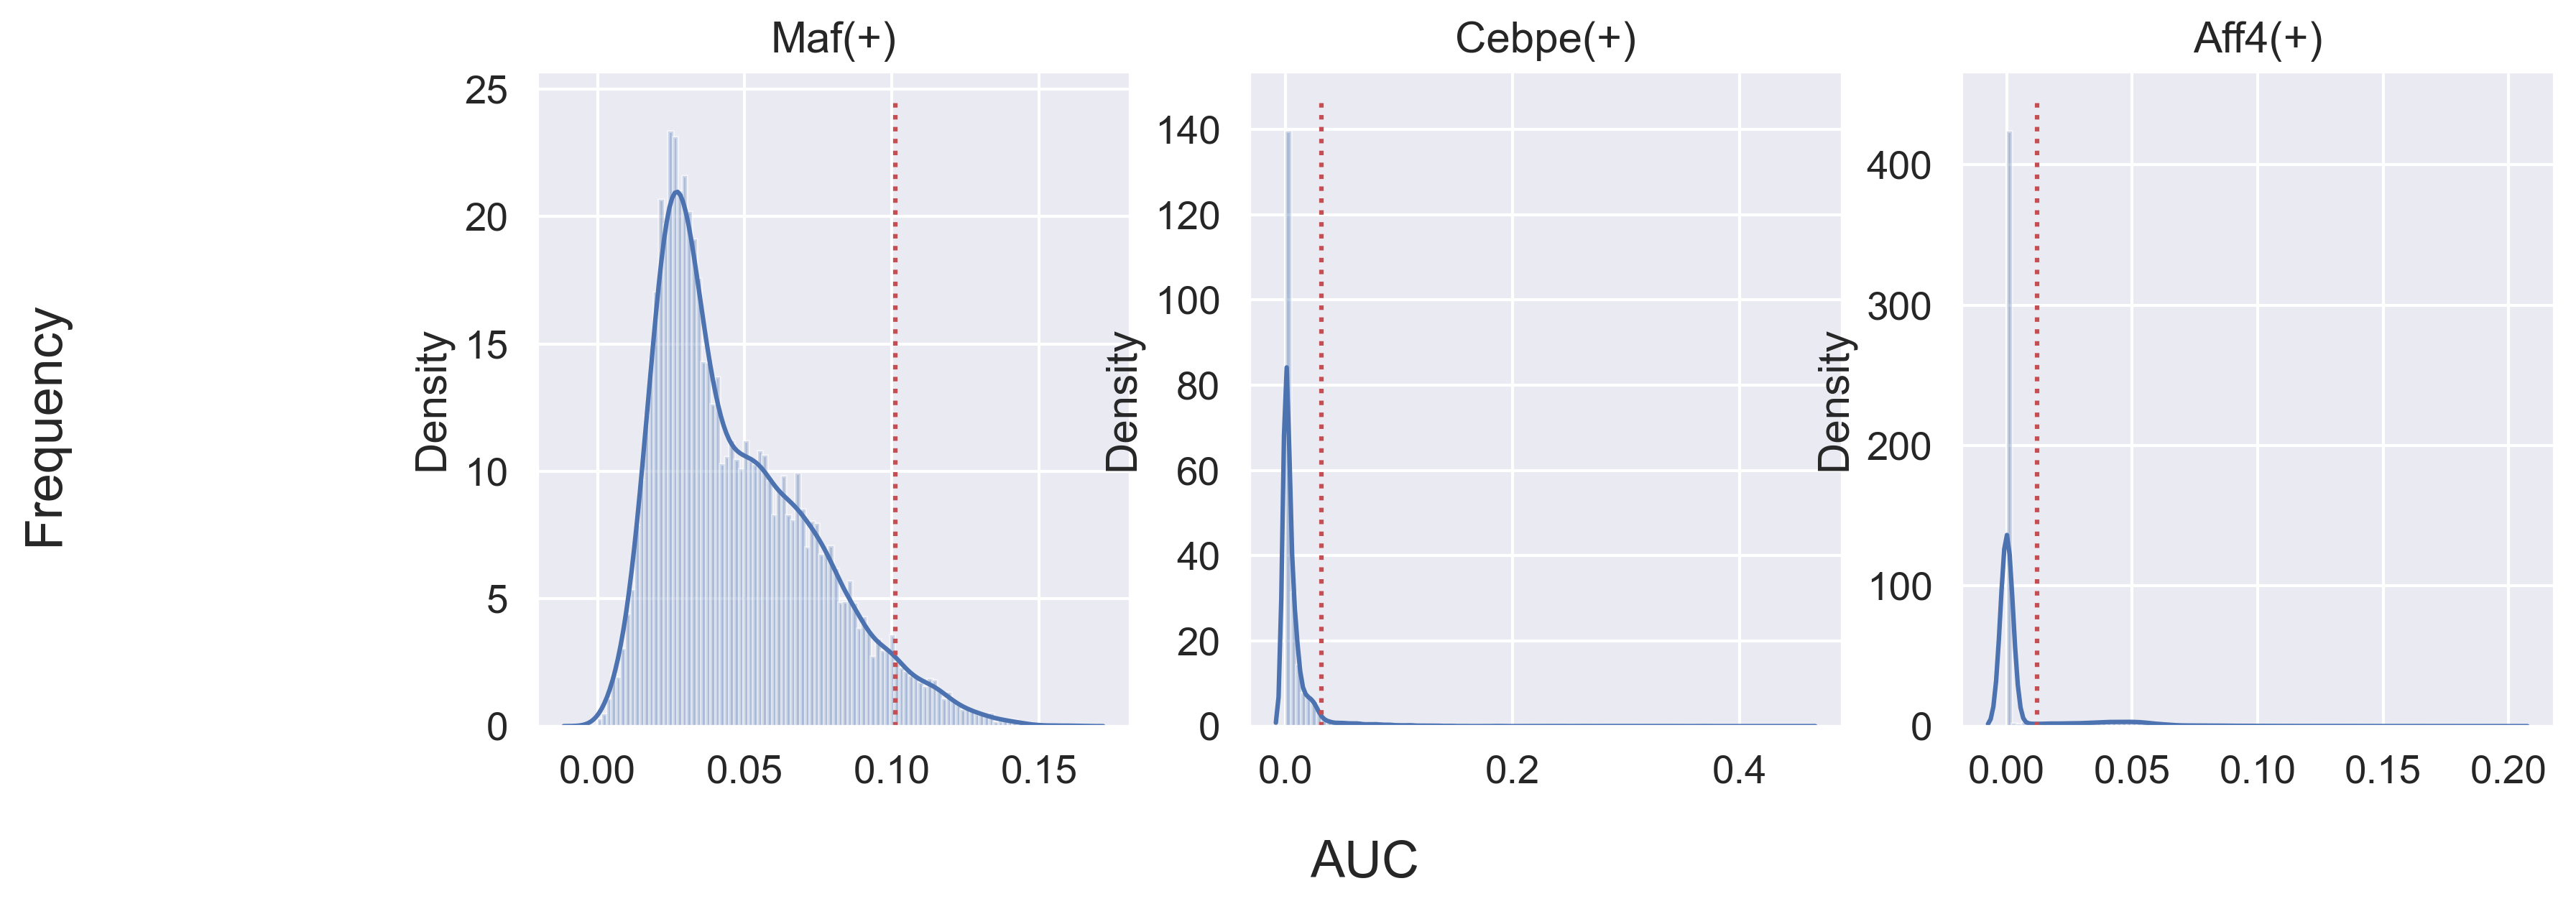

In [91]:
# select regulons:
r = [ 'Maf(+)', 'Cebpe(+)','Aff4(+)']

fig, axs = plt.subplots(1, 3, figsize=(12, 4), dpi=150, sharey=False)
for i,ax in enumerate(axs):
    sns.distplot(auc_mtx[ r[i] ], ax=ax, norm_hist=True, bins=100)
    ax.plot( [ auc_thresholds[ r[i] ] ]*2, ax.get_ylim(), 'r:')
    ax.title.set_text( r[i] )
    ax.set_xlabel('')
    
fig.text(-0.01, 0.5, 'Frequency', ha='center', va='center', rotation='vertical', size='large')
fig.text(0.5, -0.01, 'AUC', ha='center', va='center', rotation='horizontal', size='large')

#fig.tight_layout()
#fig.savefig('PBMC10k_cellType-binaryPlot2.pdf', dpi=600, bbox_inches='tight')

Further exploration of modules directly from the network inference output

In [94]:
adjacencies = pd.read_csv("adj.csv")

In [95]:
from pyscenic.utils import modules_from_adjacencies
modules = list(modules_from_adjacencies(adjacencies, exprMat))


2024-01-24 05:19:12,828 - pyscenic.utils - INFO - Calculating Pearson correlations.

2024-01-24 05:19:12,842 - pyscenic.utils - WARNING - Note on correlation calculation: the default behaviour for calculating the correlations has changed after pySCENIC verion 0.9.16. Previously, the default was to calculate the correlation between a TF and target gene using only cells with non-zero expression values (mask_dropouts=True). The current default is now to use all cells to match the behavior of the R verision of SCENIC. The original settings can be retained by setting 'rho_mask_dropouts=True' in the modules_from_adjacencies function, or '--mask_dropouts' from the CLI.
	Dropout masking is currently set to [False].

2024-01-24 05:19:14,826 - pyscenic.utils - INFO - Creating modules.


pick out modules for Cebpe:

In [97]:
tf = 'Cebpe'
tf_mods = [ x for x in modules if x.transcription_factor==tf ]

for i,mod in enumerate( tf_mods ):
    print( f'{tf} module {str(i)}: {len(mod.genes)} genes' )
print( f'{tf} regulon: {len(regulons[tf+"(+)"])} genes' )

Cebpe module 0: 34 genes
Cebpe module 1: 24 genes
Cebpe module 2: 51 genes
Cebpe module 3: 23 genes
Cebpe module 4: 39 genes
Cebpe module 5: 68 genes
Cebpe regulon: 31 genes


#Write tfs modules into a file 

In [98]:
for i,mod in enumerate( tf_mods ):
    with open( tf+'_module_'+str(i)+'.txt', 'w') as f:
        for item in mod.genes:
            f.write("%s\n" % item)
            
with open( tf+'_regulon.txt', 'w') as f:
    for item in regulons[tf+'(+)']:
        f.write("%s\n" % item)

In [ ]:
from IPython.display import display, Image
display(Image(filename='iRegulon_screenshot_PBMC10k-EBF1.png'))